In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet ###REMOVE
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [236]:
# Defining the seasons and models used
seasons = [#'2023-24','2022-23',
           '2021-22','2020-21','2019-20','2018-19','2017-18','2016-17','2015-16','2014-15','2013-14',
          '2012-13','2011-12','2010-11','2009-10','2008-09','2007-08','2006-07'
          ]
seasons.reverse()
           
models = ['SVM', 'XGBoost','Random Forest','AdaBoost','Gradient Boosting','LGBM']

path = current_path = os.getcwd()
# Path to local folder
path_data = '/Users/von/Desktop/Work/Projects/NBA_MIP_Predictor/NBA-Modelo-MVP/Modelo MVP'

sep = r'/'

In [237]:
def get_previous_season(current_season):
    years = current_season.split('-')
    
    first_year = str(int(years[0]) - 1)
    second_year = '{:02d}'.format(int(years[1]) - 1)
    return first_year + '-' + second_year

In [279]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 80)

def get_data(seasons):
    
    # Opening the data
    per_game = pd.DataFrame()
    totals = pd.DataFrame()
    difference = pd.DataFrame()
    advanced_stats = pd.DataFrame()
    standings = pd.DataFrame()
    difference_pergame = pd.DataFrame()
    difference_advanced = pd.DataFrame()

    for season in seasons:
        if season == '2004-05':
            break

        pergame = pd.read_csv(path_data+sep+'Data'+sep+season+'-PerGame.csv',
                               sep=',', decimal='.')

        total = pd.read_csv(path_data+sep+'Data'+sep+season+' Total.csv',
                            sep=',', decimal='.')
        
        advanced = pd.read_csv(path_data+sep+'Data'+sep+season+' Advanced.csv',
                               sep=',', decimal='.')
        
        pergame_previous = pd.read_csv(path_data+sep+'Data'+sep+get_previous_season(season)+'-PerGame.csv',
                               sep=',', decimal='.')
                               
        advanced_previous = pd.read_csv(path_data+sep+'Data'+sep+get_previous_season(season)+' Advanced.csv',
                               sep=',', decimal='.')
        
        standing = pd.read_csv(path_data+sep+'Data'+sep+season+' Standings.csv',
                               sep=',', decimal='.')
        
        
        # Getting dataframe for difference of stat averages from previous year
        cols_to_diff_pergame = ['G','GS','MP','FG','FGA','FG%','3P','3PA','3P%','2P','2PA','2P%','eFG%','FT','FTA','FT%','ORB','DRB','TRB','AST','STL','BLK','TOV','PTS']
        cols_to_diff_advanced = ['PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP']
        
        #difference_pergame = pd.DataFrame()
        #difference_advanced = pd.DataFrame()

        # First, make sure all Players' names are the same in every data file used
        # Using str.replace() to remove all text from *\ or \ onwards
        pergame['Player'] = pergame['Player'].str.replace(r'[\*\\].*', '', regex=True)
        pergame_previous['Player'] = pergame_previous['Player'].str.replace(r'[\*\\].*', '', regex=True)
        advanced['Player'] = advanced['Player'].str.replace(r'[\*\\].*', '', regex=True)
        advanced_previous['Player'] = advanced_previous['Player'].str.replace(r'[\*\\].*', '', regex=True)

        # Remove duplicate players, keeping only the first occurrence
        pergame= pergame.drop_duplicates(subset='Player', keep='first')
        pergame_previous= pergame_previous.drop_duplicates(subset='Player', keep='first')
        advanced= advanced.drop_duplicates(subset='Player', keep='first')
        advanced_previous= advanced_previous.drop_duplicates(subset='Player', keep='first')

        # Merge current and past season to get stats differences
        difference_pergame_season = pd.merge(pergame, pergame_previous, on='Player', suffixes=('_Current', '_Previous'), how='inner')
        difference_advanced_season = pd.merge(advanced, advanced_previous, on='Player', suffixes=('_Current', '_Previous'), how='inner')
        
        #difference_pergame_season = difference_pergame_season.drop_duplicates(subset='Player', keep='first')

        # Perform subtraction for specific columns
        
        for col in cols_to_diff_pergame:
            difference_pergame_season[col + '_diff'] = difference_pergame_season[col + '_Current'] - difference_pergame_season[col + '_Previous']
        difference_pergame_season = difference_pergame_season[[
            'Player', 'G_diff','GS_diff', 'MP_diff', 'FG_diff', 'FGA_diff', 'FG%_diff', 
            '3P_diff', '3PA_diff', '3P%_diff', '2P_diff', '2PA_diff', '2P%_diff', 'eFG%_diff',
            'FT_diff', 'FTA_diff', 'FT%_diff', 'ORB_diff', 'DRB_diff', 'TRB_diff', 'AST_diff', 
            'STL_diff', 'BLK_diff', 'TOV_diff', 'PTS_diff',
        ]]
        #difference_pergame_season['Player-additional'] = difference_pergame_season['Player-additional_Current']
        
        for col in cols_to_diff_advanced:
            difference_advanced_season[col + '_diff'] = difference_advanced_season[col + '_Current'] - difference_advanced_season[col + '_Previous']
        difference_advanced_season = difference_advanced_season[[
            'Player', 'PER_diff','TS%_diff','3PAr_diff','FTr_diff','ORB%_diff','DRB%_diff',
            'TRB%_diff','AST%_diff','STL%_diff','BLK%_diff','TOV%_diff','USG%_diff','OWS_diff',
            'DWS_diff','WS_diff','WS/48_diff','OBPM_diff','DBPM_diff','BPM_diff','VORP_diff', 
        ]]
        
        #difference_advanced_season['Player-additional'] = difference_advanced_season['Player-additional_Current']

        
        pergame['Season'] = season
        total['Season'] = season
        advanced['Season'] = season
        standing['Season'] = season
        difference_advanced_season['Season'] = season
        difference_pergame_season['Season'] = season


        
        per_game = pd.concat([per_game,pergame], ignore_index=True)
        totals = pd.concat([totals,total], ignore_index=True)
        advanced_stats = pd.concat([advanced_stats,advanced], ignore_index=True)
        standings = pd.concat([standings,standing], ignore_index=True)
        difference_pergame = pd.concat([difference_pergame, difference_pergame_season], ignore_index=True)
        difference_advanced = pd.concat([difference_advanced, difference_advanced_season], ignore_index=True)
        

        
        #difference = difference.merge(difference_advanced, on=['Player','Season','Tm'], how='left', validate='1:1')
    #print(difference_pergame)
   # print(difference_pergame.duplicated(subset=["Player"]).sum())
   #print(totals)
    #print(pergame)
    #print
    

    #Check occurances of a player
    #player_counts = difference_pergame['Player'].value_counts()
    #count = player_counts.get("DeMar DeRozan", 0)
    #print(count)


    # Need to merge advanced stats and pergame stats differences into one dataframe
    difference = pd.merge(difference_pergame, difference_advanced, on=['Player', 'Season'], how='outer', suffixes=('_pergame', '_advanced'))

    
    print(difference['Player'].value_counts()['Bam Adebayo'])

    return per_game, totals, advanced_stats, standings, difference


In [352]:
def treat_data(per_game, totals, advanced, difference, standings, seasons):
    
    # Removing duplicate/empty columns
    per_game = per_game.drop(['Rk','Pos'], axis=1)
    totals = totals.drop(['Rk','Pos','Age','G','GS'], axis=1)
    advanced = advanced.drop(['Rk','Pos','Age','G','MP','Unnamed: 24','Unnamed: 19'], axis=1)
    
    cols = ['Player','Season','Pos','Age','Tm','G','GS']

    previous_winners = []
    
    # Identifying the variables
    for col in per_game.columns:
        if col not in cols:
            new_col = col+'_PERGAME'
            per_game = per_game.rename(columns={col:new_col})
    for col in totals.columns:
        if col not in cols:
            new_col = col+'_TOTAL'
            totals = totals.rename(columns={col:new_col})
    for col in advanced.columns:
        if col not in cols:
            new_col = col+'_ADVANCED'
            advanced = advanced.rename(columns={col:new_col})
    
    # Merging the bases
    data = per_game.merge(advanced, on=['Player','Season','Tm'], how='left', validate='1:1')
    #data = data.merge(totals, on=['Player','Season','Tm'], how='left', validate='1:1')
    data = data.merge(difference, on=['Player','Season',], how='left', validate='1:1')
    
    dict_teams = {'Utah Jazz':'UTA','Phoenix Suns':'PHO',
                 'Philadelphia 76ers':'PHI','Brooklyn Nets':'BRK',
                 'Denver Nuggets':'DEN','Los Angeles Clippers':'LAC',
                 'Milwaukee Bucks':'MIL','Dallas Mavericks':'DAL',
                 'Los Angeles Lakers':'LAL','Portland Trail Blazers':'POR',
                 'Atlanta Hawks':'ATL','New York Knicks':'NYK',
                 'Miami Heat':'MIA','Golden State Warriors':'GSW',
                 'Memphis Grizzlies':'MEM','Boston Celtics':'BOS',
                 'Washington Wizards':'WAS','Indiana Pacers':'IND',
                 'Charlotte Hornets':'CHO','Charlotte Bobcats':'CHA',
                 'San Antonio Spurs':'SAS','Chicago Bulls':'CHI',
                 'New Orleans Pelicans':'NOP','Sacramento Kings':'SAC',
                 'Toronto Raptors':'TOR','Minnesota Timberwolves':'MIN',
                 'Cleveland Cavaliers':'CLE','Oklahoma City Thunder':'OKC',
                 'Orlando Magic':'ORL','Detroit Pistons':'DET',
                 'Houston Rockets':'HOU','New Jersey Nets':'NJN',
                 'New Orleans Hornets':'NOH','Seattle SuperSonics':'SEA'}
    
    teams = pd.DataFrame.from_dict(dict_teams, orient='index').reset_index()
    teams = teams.rename(columns={'index':'Team',0:'Tm'})
    standings = standings.merge(teams, on='Team', how='left', validate='m:1')
    wins = (standings['Record'].str.split('-',expand=True)[0]).astype(int)
    games = ((standings['Record'].str.split('-',expand=True)[0]).astype(int)+(standings['Record'].str.split('-',expand=True)[1]).astype(int))
    standings['PCT'] = wins/games
    
    data = data.merge(standings, on=['Tm','Season'], how='left', validate='m:1')
    
    data['Player'] = data['Player'].str.replace('*','')
    
    ###mvps = pd.read_csv(path_data+sep+'Dados'+sep+'MVPs.csv',sep=',', decimal='.') ###Change to MIPS

    mips = pd.read_csv(path_data+sep+'Data'+sep+'MIPs.csv',sep=',', decimal='.')


    ###data = data.merge(mvps, on=['Player','Season'], how='left', validate='m:1').fillna(0)  
    data = data.merge(mips, on=['Player','Season'], how='left', validate='m:1').fillna(0) 

    data['Player'] = data['Player'].str.split('\\', expand=True)[0]
    #print(data)
    
    # Removing duplicate lines from traded players, removing players from seasons that have already won the award
    dataf = pd.DataFrame()
    for season in seasons:
        data_season = data[data['Season']==season]
        data_season = data_season.drop_duplicates(subset=['Player'], keep='first')

        # Remove players who already won
        data_season = data_season[~data_season['Player'].isin(previous_winners)]

        result = mips[(mips['MIP Rank'] == '1') & (mips['Season'] == season)]
        print(result)
        #print(mips[(mips['MIP Rank'] == '1') & (mips['Season'] == season)])
        
        # Add winning player to winners list
        winner_name = result['Player'].tolist()[0]
        if winner_name not in previous_winners:
            previous_winners.append(winner_name)
            print(winner_name)
        
        
        print(season)
        dataf = pd.concat([dataf,data_season], ignore_index=True)

    
    # Filtering the data (MVP)
    '''
    dataf = dataf[((dataf['G']>48)&(dataf['PTS_PERGAME']>13.5)&(dataf['MP_PERGAME']>30)
                 &(dataf['Seed']<=16)&(dataf['AST_PERGAME']>1)&(dataf['TRB_PERGAME']>3)
                 &(dataf['Tm']!='TOT')&(dataf['FG%_PERGAME']>0.37)&(dataf['FGA_PERGAME']>10)
                 &(dataf['PER_ADVANCED']>18)) | (dataf['MVP Votes Share']>0)].reset_index(drop=True)
    '''
    # Filtering the data (MIP)
    dataf = dataf[((dataf['G']>50)&(dataf['Age'] <= 30)&(dataf['PTS_PERGAME']>=9.7)
                   &(dataf['FGA_PERGAME']>=7.8)&(dataf['MP_PERGAME']>=22.9)&(dataf['PER_ADVANCED']>=14.2)
                   &(dataf['TRB_PERGAME']>=2.6)&(dataf['AST_PERGAME']>=0.7)&(dataf['PER_ADVANCED']>0.41)
                   &(dataf['PTS_diff']>=1.3)&(dataf['TRB_diff']>=-1.0) 
                   &(dataf['AST_diff']>=-1.5)| (dataf['MIP Share']>0))].reset_index(drop=True)
    
    # Base for the criteria:
    # Karl Malone was MVP in 98-99 with 49 games
    # Wes Unseld was MVP at 68-69 with 13.8 PPG and with 10.9 FGA
    # Steve Nash was MVP at 04-05 with 3.3 REB
    # Moses Malone was MVP at 82-83 with 1.3 AST
    # Bob Cousy was MVP at 56-57 with 37.8% FG
    # Giannis Antetokounmpo was MVP in 19-20 with 30.4 min
    # Kareem Abdul-Jabbar was the only MVP not to make the playoffs in 1976 (40-42)
    # Dave Cowens was MVP at 72-73 with a PER of 18.1
    # Never has an MVP been traded in the middle of the season that he won the award


    # Base for the MIP criteria
    # Darrell Armstrong was MIP in 98-99 with 50 games, oldest age 30
    # Isaac Austin was MIP in 96-97 with 9.7 PPG, 7.8 FGA, 22.9 MPG, 14.2 PER
    # Aaron Brooks was MIP in 2009-10 with 2.6 RPG
    # Gheorghe Muresan was MIP in 95-96 with 0.7 APG
    # Paul George was MIP in 2012-13 with 41.9% FG
    # 
    
    # Since 2001-02
    # PPG difference >= 4.5
    # PPG diff of top 3 candidates >= 1.3
    # RPG diff top 3 >=  -1.0
    # APG diff top3 >= -1.5
    # Season before >= 41 games played
    # 

    

        
    dataf = dataf.drop(['Tm','Team','Record'], axis=1)
    
    return dataf

In [322]:
per_game, totals, advanced, standings, difference = get_data(seasons)


#per_game
#print("Breaks")
difference

4


Player  G_diff  GS_diff  MP_diff  FG_diff  FGA_diff  \
0             Precious Achiuwa      12       24     11.5      1.6       4.6   
1                 Steven Adams      18       17     -1.4     -0.5      -0.2   
2                  Bam Adebayo      -8       -8     -0.9      0.2       0.5   
3            LaMarcus Aldridge      21      -11     -3.6      0.0      -1.7   
4     Nickeil Alexander-Walker      19        8      0.7     -0.3       0.5   
...                        ...     ...      ...      ...      ...       ...   
6244         Metta World Peace      14        9     -1.7      0.2      -0.6   
6245            Antoine Wright      24       23      8.5      1.0       1.9   
6246             Bracey Wright      12        0     -9.3     -1.7      -4.1   
6247             Dorell Wright      46       17     13.0      1.5       3.3   
6248           Lorenzen Wright     -11      -27     -6.3     -1.3      -2.5   

      FG%_diff  3P_diff  3PA_diff  3P%_diff  2P_diff  2PA_diff  2P%_diff  \
0       -0.105      0.8       2.1     0.359      0.9       2.4    -0.078   
1       -0.067      0.0      -0.1     0.000     -0.5      -0.3    -0.072   
2       -0.013      0.0       0.0    -0.250      0.2       0.5    -0.011   
3        0.077     -0.9      -2.1    -0.084      0.9       0.5     0.073   
4       -0.047     -0.1       0.4    -0.036     -0.2       0.1    -0.052   
...        ...      ...       ...       ...      ...       ...       ...   
6244     0.036     -0.1      -0.8     0.050      0.3       0.1     0.025   
6245     0.080      0.3       0.5     0.255      0.7       1.3     0.050   
6246    -0.012     -0.6      -1.3    -0.053     -1.2      -2.8     0.009   
6247    -0.020     -0.1       0.2    -0.353      1.5       3.1     0.017   
6248    -0.030      0.0       0.0       NaN     -1.3      -2.5    -0.032   

      eFG%_diff  FT_diff  FTA_diff  FT%_diff  ORB_diff  DRB_diff  TRB_diff  \
0        -0.058      0.2       0.0     0.086       0.8       2.3       3.1   
1        -0.067      0.4       0.3     0.099       0.9       0.2       1.1   
2        -0.014      0.2       0.6    -0.046       0.2       0.9       1.1   
3         0.041      0.3       0.4     0.001       0.9       0.1       1.0   
4        -0.053      0.2       0.3     0.016       0.3      -0.5      -0.2   
...         ...      ...       ...       ...       ...       ...       ...   
6244      0.036      0.7       0.5     0.065       0.2       1.2       1.4   
6245      0.112      0.4       0.6     0.103       0.4       1.6       2.0   
6246     -0.021     -1.3      -1.4    -0.153       0.0      -1.4      -1.5   
6247     -0.048      0.2       0.4    -0.138       0.5       2.0       2.5   
6248     -0.030     -0.7      -1.0    -0.283      -0.5      -1.2      -1.9   

      AST_diff  STL_diff  BLK_diff  TOV_diff  PTS_diff   Season  PER_diff  \
0          0.6       0.2       0.1       0.5       4.1  2021-22      -1.5   
1          1.5       0.0       0.1       0.2      -0.7  2021-22       2.5   
2         -2.0       0.2      -0.2       0.0       0.4  2021-22      -0.9   
3         -1.0      -0.1      -0.1      -0.1      -0.6  2021-22       3.9   
4          0.2      -0.3      -0.1      -0.1      -0.4  2021-22      -2.0   
...        ...       ...       ...       ...       ...      ...       ...   
6244      -0.2      -0.1      -0.1      -0.2       1.2  2006-07       3.3   
6245       0.6       0.4       0.1       0.2       2.7  2006-07       7.4   
6246       0.1       0.4       0.1      -0.8      -5.4  2006-07       1.7   
6247       1.0       0.4       0.6       0.3       3.1  2006-07      -0.5   
6248       0.0      -0.3      -0.2      -0.3      -3.2  2006-07      -5.6   

      TS%_diff  3PAr_diff  FTr_diff  ORB%_diff  DRB%_diff  TRB%_diff  \
0       -0.047      0.255    -0.265       -2.8        1.1       -1.2   
1       -0.036     -0.007     0.080        3.5        1.6        2.5   
2       -0.018     -0.002     0.023        1.0        3.5        2.2   
3        0.0

In [353]:
data = treat_data(per_game, totals, advanced, difference, standings, seasons)

   MIP Rank     Player  MIP Share   Season Won already
27        1  Ja Morant      0.442  2021-22           N
Ja Morant
2021-22
   MIP Rank         Player  MIP Share   Season Won already
39        1  Julius Randle      0.986  2020-21           N
Julius Randle
2020-21
   MIP Rank          Player  MIP Share   Season Won already
64        1  Brandon Ingram      0.652  2019-20           N
Brandon Ingram
2019-20
   MIP Rank         Player  MIP Share   Season Won already
79        1  Pascal Siakam      0.938  2018-19           N
Pascal Siakam
2018-19
    MIP Rank          Player  MIP Share   Season Won already
101        1  Victor Oladipo      0.988  2017-18           N
Victor Oladipo
2017-18
    MIP Rank                 Player  MIP Share   Season Won already
133        1  Giannis Antetokounmpo      0.856  2016-17           N
Giannis Antetokounmpo
2016-17
    MIP Rank       Player  MIP Share   Season Won already
158        1  CJ McCollum       0.86  2015-16           N
CJ McCollum
2015-16
  

In [291]:
pd.options.display.max_rows = 200
data

Player  Age   G  GS  MP_PERGAME  FG_PERGAME  FGA_PERGAME  \
0            Jarrett Allen   23  56  56        32.3         6.6          9.7   
1    Giannis Antetokounmpo   27  67  67        32.9        10.3         18.6   
2            Deandre Ayton   23  58  58        29.5         7.6         12.0   
3              LaMelo Ball   20  75  75        32.3         7.2         16.7   
4                 Mo Bamba   23  71  69        25.7         4.2          8.7   
..                     ...  ...  ..  ..         ...         ...          ...   
731            Luke Walton   26  60  60        33.0         4.4          9.3   
732          Hakim Warrick   24  82  43        26.2         4.5          8.7   
733           Chris Wilcox   24  82  81        31.5         5.3         10.0   
734         Deron Williams   22  80  80        36.9         6.2         13.5   
735            Mo Williams   24  68  68        36.4         6.9         15.4   

     FG%_PERGAME  3P_PERGAME  3PA_PERGAME  3P%_PERGAME  2P_PERGAME  \
0          0.677         0.0          0.2        0.100         6.6   
1          0.553         1.1          3.6        0.293         9.2   
2          0.634         0.1          0.3        0.368         7.5   
3          0.429         2.9          7.5        0.389         4.2   
4          0.480         1.5          4.0        0.381         2.7   
..           ...         ...          ...          ...         ...   
731        0.474         0.8          2.1        0.387         3.6   
732        0.524         0.0          0.1        0.000         4.5   
733        0.529         0.0          0.1        0.000         5.3   
734        0.456         1.0          3.2        0.322         5.2   
735        0.446         1.2          3.4        0.346         5.7   

     2PA_PERGAME  2P%_PERGAME  eFG%_PERGAME  FT_PERGAME  FTA_PERGAME  \
0            9.6        0.688         0.678         2.9          4.2   
1           15.0        0.616         0.582         8.3         11.4   
2           11.7        0.642         0.639         1.8          2.4   
3            9.2        0.462         0.517         2.8          3.2   
4            4.7        0.563         0.566         0.8          1.0   
..           ...          ...           ...         ...          ...   
731          7.2        0.499         0.517         1.8          2.4   
732          8.6        0.530         0.524         3.6          4.7   
733          9.9        0.533         0.529         2.9          4.3   
734         10.4        0.498         0.494         2.8          3.7   
735         12.1        0.474         0.484         2.3          2.7   

     FT%_PERGAME  ORB_PERGAME  DRB_PERGAME  TRB_PERGAME  AST_PERGAME  \
0          0.708          3.4          7.3         10.8          1.6   
1          0.722          2.0          9.6         11.6          5.8   
2          0.746          2.6          7.7         10.2          1.4   
3          0.872          1.4          5.2          6.7          7.6   
4          0.781          2.1          6.0          8.1          1.2   
..           ...          ...          ...          ...          ...   
731        0.745          1.5          3.6          5.0          4.3   
732        0.771          1.6          3.5          5.1          0.9   
733        0.684          2.2          5.5          7.7          1.0   
734        0.767          0.5          2.8          3.3          9.3   
735        0.855          0.8          4.0          4.8          6.1   

     STL_PERGAME  BLK_PERGAME  TOV_PERGAME  PF_PERGAME  PTS_PERGAME   Season  \
0            0.8          1.3          1.7         1.7         16.1  2021-22   
1            1.1          1.4          3.3         3.2         29.9  2021-22   
2            0.7          0.7          1.6         2.4         17.2  2021-22   
3            1.6          0.4          3.3         3.2         20.1  2021-22   
4            0.5          1.7          1.1         2.6         10.6  2021-22   
..      

In [292]:
pd.options.display.max_rows = 4000
pd.options.display.max_seq_items = 4000
data.columns

Index(['Player', 'Age', 'G', 'GS', 'MP_PERGAME', 'FG_PERGAME', 'FGA_PERGAME',
       'FG%_PERGAME', '3P_PERGAME', '3PA_PERGAME', '3P%_PERGAME', '2P_PERGAME',
       '2PA_PERGAME', '2P%_PERGAME', 'eFG%_PERGAME', 'FT_PERGAME',
       'FTA_PERGAME', 'FT%_PERGAME', 'ORB_PERGAME', 'DRB_PERGAME',
       'TRB_PERGAME', 'AST_PERGAME', 'STL_PERGAME', 'BLK_PERGAME',
       'TOV_PERGAME', 'PF_PERGAME', 'PTS_PERGAME', 'Season', 'PER_ADVANCED',
       'TS%_ADVANCED', '3PAr_ADVANCED', 'FTr_ADVANCED', 'ORB%_ADVANCED',
       'DRB%_ADVANCED', 'TRB%_ADVANCED', 'AST%_ADVANCED', 'STL%_ADVANCED',
       'BLK%_ADVANCED', 'TOV%_ADVANCED', 'USG%_ADVANCED', 'OWS_ADVANCED',
       'DWS_ADVANCED', 'WS_ADVANCED', 'WS/48_ADVANCED', 'OBPM_ADVANCED',
       'DBPM_ADVANCED', 'BPM_ADVANCED', 'VORP_ADVANCED', 'G_diff', 'GS_diff',
       'MP_diff', 'FG_diff', 'FGA_diff', 'FG%_diff', '3P_diff', '3PA_diff',
       '3P%_diff', '2P_diff', '2PA_diff', '2P%_diff', 'eFG%_diff', 'FT_diff',
       'FTA_diff', 'FT%_diff', 'ORB_d

In [293]:
data['Season'].value_counts() # Number of players in the data per season\

2013-14    55
2017-18    52
2012-13    51
2018-19    50
2008-09    50
2016-17    49
2010-11    49
2006-07    48
2007-08    47
2020-21    46
2009-10    44
2015-16    42
2011-12    40
2014-15    39
2019-20    38
2021-22    36
Name: Season, dtype: int64

In [295]:
# Function for metrics
def func_metrics(y_test, y_pred, metrics, model, season):
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3) # RMSE
    r2 = round(r2_score(y_test, y_pred),3) # R²
    
    dict_met = {'Model': [model],
                'Season': [season],
                'RMSE': [rmse],
                'R²': [r2]}
    
    metric = pd.DataFrame(data=dict_met)
    metrics = pd.concat([metrics,metric])
    
    return metrics

In [294]:
def func_models(data, seasons, models, n_seasons_to_test):
    final_results = pd.DataFrame()
    metrics = pd.DataFrame()
    best_params = []
    i = 1

    for season in seasons:

        # Separating training and testing bases
        season_test = season

        data_train = data[data['Season']!=season_test]
        data_test = data[data['Season']==season_test]

        #X_train = data_train.drop(['MVP Votes Share','MVP Rank','Player','Season'], axis=1)
        #y_train = data_train['MVP Votes Share']
        X_train = data_train.drop(['MIP Share','MIP Rank','Player','Season'], axis=1)
        y_train = data_train['MIP Share']

        X_test = data_test.drop(['MIP Share','MIP Rank','Player','Season'], axis=1)
        y_test = data_test['MIP Share']

        initial_results = data_test[['Player','Season','MIP Share','MIP Rank']]
        results = initial_results.copy()

        scaler = StandardScaler()

        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        for model in models:
            # Creating instance for each model
            if model=='SVM':
                param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5,10],
                             'kernel': ['linear','rbf','poly'],
                             'gamma': ['scale','auto'],
                             'degree': [2,3,4],
                             'epsilon': [0.1,0.5,1]}
                svr_model = SVR()
                grid = GridSearchCV(svr_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = SVR(**grid.best_params_)
                best_params.append(grid.best_params_)

            elif model=='Elastic Net':
                param_grid = {'alpha':[0.01,0.1,1,5,10,50,100],
                              'l1_ratio':[0.01,0.1,0.5,0.7,0.95,0.99,1]}
                elastic_net_model = ElasticNet()
                grid = GridSearchCV(elastic_net_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                grid.best_params_
                final_model = ElasticNet(**grid.best_params_)
                best_params.append(grid.best_params_)
            elif model=='XGBoost':
                param_grid = {'n_estimators': [100, 200],
                              'learning_rate': [0.01, 0.1],
                              'max_depth': [3, 5, 7],
                              'subsample': [0.7, 1.0]}
                xg_boost = XGBRegressor()
                grid = GridSearchCV(xg_boost, param_grid)
                grid.fit(scaled_X_train, y_train)
                grid.best_params_
                final_model = XGBRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='Random Forest':
                param_grid = {'n_estimators': [15,25,50,64,100,150,200],
                             'max_features': [2,3,4,5],
                             'bootstrap': [True,False],
                             'oob_score': [True]}
                rfc = RandomForestRegressor()
                grid = GridSearchCV(rfc, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = RandomForestRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='AdaBoost':
                param_grid = {'n_estimators': [5,10,20,30,40,50,100],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5]}
                ada_model = AdaBoostRegressor()
                grid = GridSearchCV(ada_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = AdaBoostRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='Gradient Boosting':
                param_grid = {'n_estimators': [10,20,30,40,50],
                             'learning_rate': [0.01,0.05,0.1,0.2,0.5],
                             'max_depth': [3,4,5]}
                gb_model = GradientBoostingRegressor()
                grid = GridSearchCV(gb_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = GradientBoostingRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            elif model=='LGBM':
                param_grid = {'learning_rate':[0.01,0.1,0.2,0.3],
                              'num_leaves':[5,10,20,30],
                              'min_data_in_leaf':[10,25,50],
                              'max_depth':[2,3,4],
                              'feature_fraction':[0.6,0.7,0.8,0.9],
                              'min_gain_to_split':[0,0.01,0.1,0.2],
                              'verbose':[-1]}
                lgbm_model = LGBMRegressor()
                grid = GridSearchCV(lgbm_model, param_grid)
                grid.fit(scaled_X_train, y_train)
                final_model = LGBMRegressor(**grid.best_params_)
                best_params.append(grid.best_params_)
                
            final_model.fit(scaled_X_train, y_train)
            
            print("FM:")
            print(final_model)
            print("SEP: ")
            print(sep)
            print("MODEL: ")
            print(model)
            pickle.dump(final_model,open(path_data+sep+'Models'+sep+model+'.dat','wb'))#,'wb')
            
            y_pred = final_model.predict(scaled_X_test)
            metrics = func_metrics(y_test, y_pred, metrics, model, season)

            temp_df = initial_results.copy()
            temp_df['Predicted MIP Share '+model] = pd.Series(y_pred).values

            results_sorted = temp_df.sort_values(by='Predicted MIP Share '+model,
                                                ascending=False).reset_index(drop=True)
            results_sorted['MIP Rank '+model] = results_sorted.index+1

            results = results.merge(results_sorted, on=['Player','Season','MIP Share','MIP Rank'])

        final_results = pd.concat([final_results,results], ignore_index=True)

        if i == n_seasons_to_test:
            break

        i = i + 1
    
    np.savetxt(path_data+sep+r'Models\params.csv', best_params, delimiter =', ', fmt ='% s')
    
    return final_results, metrics, best_params

In [296]:
def average_metrics(metrics):
    # Averages of each of the models
    final_metrics = pd.DataFrame()
    for model in metrics['Model'].unique():
        metric = metrics[metrics['Model']==model]
        rmse = round(metric['RMSE'].mean(),3)
        r2 = round(metric['R²'].mean(),3)

        dict_met = {'Model': [model],
                    'RMSE': [rmse],
                    'R²': [r2]}

        data_frame = pd.DataFrame(data=dict_met)
        final_metrics = pd.concat([final_metrics,data_frame], ignore_index=True)
    return final_metrics

In [305]:
pd.options.display.max_rows = 50

final_results, metrics, best_params = func_models(data, seasons, models, 1)
final_metrics = average_metrics(metrics)
final_metrics

FM:
SVR(C=0.5, degree=2, gamma='auto')
SEP: 
/
MODEL: 
SVM
FM:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
SEP: 
/
MODEL: 
XGBoost
FM:
RandomForestRegressor(max_features=3, n_estimators=150, oob_score=True)
SEP: 
/
MODEL: 
Random Forest
FM:
AdaBoostRegressor(learning_rate=0.1, n_estimators=100)
SEP: 

Model   RMSE     R²
0                SVM  0.090  0.380
1            XGBoost  0.093  0.345
2      Random Forest  0.084  0.469
3           AdaBoost  0.097  0.284
4  Gradient Boosting  0.103  0.192
5               LGBM  0.083  0.478

In [301]:
def create_rank(final_results, n_rank):
    rank_final = pd.DataFrame()

    for season in final_results['Season'].unique():
        temp = final_results[final_results['Season']==season]
        rank = pd.DataFrame()
        rank_real = temp.sort_values(by='MIP Share', ascending=False)[:n_rank].reset_index(drop=True)
        rank['MIP Rank Real'] = rank_real['Player']
        rank['MIP Share Real'] = rank_real['MIP Share']
        for model in models:
            try:
                temp2 = temp.sort_values(by='Predicted MIP Share '+model, ascending=False)[:n_rank].reset_index(drop=True)
                rank['MIP Rank '+model] = temp2['Player']
                rank['MIP Share '+model] = round(temp2['Predicted MIP Share '+model],3)
            except:
                continue

        rank['Season'] = season    
        rank_final = pd.concat([rank_final, rank], ignore_index=True)
    
    return rank_final

In [302]:
rank_final = create_rank(final_results, 3)
rank_final

MIP Rank Real  MIP Share Real     MIP Rank SVM  MIP Share SVM  \
0        Ja Morant           0.442  Dejounte Murray          0.315   
1  Dejounte Murray           0.366     Desmond Bane          0.268   
2   Darius Garland           0.356    Miles Bridges          0.249   

  MIP Rank XGBoost  MIP Share XGBoost MIP Rank Random Forest  \
0        Ja Morant              0.128              Ja Morant   
1     Desmond Bane              0.124           Tyrese Maxey   
2  Dejounte Murray              0.118           Desmond Bane   

   MIP Share Random Forest MIP Rank AdaBoost  MIP Share AdaBoost  \
0                    0.179      Desmond Bane               0.396   
1                    0.168     Miles Bridges               0.254   
2                    0.142         Ja Morant               0.138   

  MIP Rank Gradient Boosting  MIP Share Gradient Boosting    MIP Rank LGBM  \
0                  Ja Morant                        0.228     Desmond Bane   
1               Desmond Bane                        0.215    Miles Bridges   
2              Miles Bridges                        0.121  Dejounte Murray   

   MIP Share LGBM   Season  
0           0.221  2021-22  
1           0.194  2021-22  
2           0.186  2021-22

##  Old Seasons

In [303]:
def temporadas_antigas(data, seasons, models, n_seasons_to_test):
    final_results = pd.DataFrame()
    metrics = pd.DataFrame()
    best_params = []
    i = 1

    for season in seasons:
            
        # Separating training and testing bases
        season_test = season

        data_train = data[data['Season']!=season_test]
        data_test = data[data['Season']==season_test]

        X_train = data_train.drop(['MIP Share','MIP Rank','Player','Season'], axis=1)
        y_train = data_train['MIP Share']

        X_test = data_test.drop(['MIP Share','MIP Rank','Player','Season'], axis=1)
        y_test = data_test['MIP Share']

        initial_results = data_test[['Player','Season','MIP Share','MIP Rank']]
        results = initial_results.copy()

        scaler = StandardScaler()

        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        for model in models:
            
            if model=='Elastic Net':
                continue
            
            # Opening the models already created          
            current_model = pickle.load(open(path_data+sep+'Models'+sep+model+'.dat', 'rb'))
                
            current_model.fit(scaled_X_train, y_train)
            y_pred = current_model.predict(scaled_X_test)
            metrics = func_metrics(y_test, y_pred, metrics, model, season)

            apoio = initial_results.copy()
            apoio['Predicted MIP Share '+model] = pd.Series(y_pred).values

            results_sorted = apoio.sort_values(by='Predicted MIP Share '+model,
                                                ascending=False).reset_index(drop=True)
            results_sorted['MIP Rank '+model] = results_sorted.index+1

            results = results.merge(results_sorted, on=['Player','Season','MIP Share','MIP Rank'])

        final_results = pd.concat([final_results,results], ignore_index=True)

        if i == n_seasons_to_test:
            break

        i = i + 1
        
    return final_results, metrics

In [306]:
pd.options.display.max_rows = 100
pd.options.display.max_seq_items = 100
final_results, metrics = temporadas_antigas(data, seasons, models, 16)
final_metricas = average_metrics(metrics)
final_metricas

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=0.01, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM]

Model   RMSE     R²
0                SVM  0.113  0.098
1            XGBoost  0.110  0.155
2      Random Forest  0.110  0.156
3           AdaBoost  0.111  0.132
4  Gradient Boosting  0.115  0.086
5               LGBM  0.105  0.222

In [311]:
pd.options.display.max_rows = 400

rank_final = create_rank(final_results, 25)
rank_final

MIP Rank Real  MIP Share Real             MIP Rank SVM  \
0                   Ja Morant           0.442          Dejounte Murray   
1             Dejounte Murray           0.366             Desmond Bane   
2              Darius Garland           0.356            Miles Bridges   
3                Jordan Poole           0.262              LaMelo Ball   
4                Desmond Bane           0.148           Darius Garland   
5                Tyrese Maxey           0.104             Tyrese Maxey   
6               Miles Bridges           0.076                Ja Morant   
7             Anfernee Simons           0.026             Jordan Poole   
8             Robert Williams           0.008                Josh Hart   
9           Jaren Jackson Jr.           0.006          Anfernee Simons   
10              Jalen Brunson           0.004          Anthony Edwards   
11                  Max Strus           0.002               Trae Young   
12              Jarrett Allen           0.000          Robert Williams   
13               Monte Morris           0.000        Spencer Dinwiddie   
14               Bobby Portis           0.000             Jakob Poeltl   
15               Jusuf Nurkić           0.000        Tyrese Haliburton   
16               Jakob Poeltl           0.000              Joel Embiid   
17              Pascal Siakam           0.000       Wendell Carter Jr.   
18             Gary Trent Jr.           0.000            Jarrett Allen   
19                 Malik Monk           0.000    Giannis Antetokounmpo   
20            Cameron Johnson           0.000                Max Strus   
21                 Kyle Kuzma           0.000              Tyler Herro   
22             Keldon Johnson           0.000            Pascal Siakam   
23      Giannis Antetokounmpo           0.000             Bobby Portis   
24                Tyler Herro           0.000        Jaren Jackson Jr.   
25              Julius Randle           0.986             Nikola Jokić   
26               Jerami Grant           0.280            Julius Randle   
27         Michael Porter Jr.           0.276             Jerami Grant   
28             Christian Wood           0.088       Michael Porter Jr.   
29                Zach LaVine           0.040          Zion Williamson   
30              Chris Boucher           0.020              Joel Embiid   
31               Jaylen Brown           0.020             Jaylen Brown   
32              Mikal Bridges           0.016             Enes Freedom   
33            Zion Williamson           0.012  Shai Gilgeous-Alexander   
34               Jordan Poole           0.006             Clint Capela   
35             Darius Garland           0.006            Mikal Bridges   
36               Clint Capela           0.006            Chris Boucher   
37            Jordan Clarkson           0.006              Zach LaVine   
38             Nikola Vučević           0.006           Darius Garland   
39              Luguentz Dort           0.006            Kyle Anderson   
40              Kyle Anderson           0.004         Donovan Mitchell   
41              Miles Bridges           0.004             Kelly Olynyk   
42                 RJ Barrett           0.004            Fred VanVleet   
43             Andrew Wiggins           0.002        Jonas Valančiūnas   
44    Shai Gilgeous-Alexander           0.002             Terry Rozier   
45             Richaun Holmes           0.002             Jordan Poole   
46                 Lonzo Ball           0.002              Paul George   
47           Bojan Bogdanović           0.002           T.J. McConnell   
48             T.J. McConnell           0.002               Lonzo Ball   
49               Terry Rozier           0.002           Nikola Vučević   
50             Brandon Ingram           0.652             Jayson Tatum   
51                Bam Adebayo           0.590              Bam Adebayo   
52                Luka Dončić           0.202          Devonte' Graham   
53               Jay

In [315]:
data_test = data[data['Season']=='2021-22']
data_train = data[data['Season']!='2021-22']

X_test = data_test.drop(['MIP Share','MIP Rank','Player','Season'], axis=1)
X_train = data_train.drop(['MIP Share','MIP Rank','Player','Season'], axis=1)

scaler = StandardScaler()
scaler.fit(X_train)
feature_names = X_test.columns

scaled_X_test = scaler.transform(X_test)
scaled_X_test_df = pd.DataFrame(scaled_X_test, columns=feature_names)
scaled_X_test_df

Age         G        GS  MP_PERGAME  FG_PERGAME  FGA_PERGAME  \
0  -0.616062 -1.676715 -0.098006    0.143069    0.265132    -0.838887   
1   0.894423 -0.528178  0.367824    0.271630    2.391769     1.493331   
2  -0.616062 -1.467890 -0.013309   -0.456880    0.839898    -0.236179   
3  -1.748926  0.307122  0.706610    0.143069    0.609992     0.995441   
4  -0.616062 -0.110528  0.452521   -1.271096   -1.114309    -1.100934   
5  -0.616062  0.411534  0.748958   -0.392599    0.322608     0.418938   
6  -0.616062  0.829184  0.918351    0.828726    0.782422     0.602371   
7   0.139180  0.724772  0.113735    0.057362    0.150178    -0.026542   
8  -0.993684 -1.050240  0.113735   -0.371173   -0.194682    -0.498226   
9   1.272045 -0.528178 -0.309747   -0.435453   -0.884402    -0.498226   
10 -1.748926 -0.006116  0.579565    0.571605    0.839898     1.152670   
11  0.894423 -0.423766  0.410172    0.464471    2.104385     1.755378   
12 -0.993684 -0.423766  0.410172    0.871579    1.069805     1.152670   
13  0.516802  0.307122  0.706610    0.014509   -0.194682    -0.472021   
14 -1.371305  0.515947  0.791306    0.721592   -0.309635    -0.288589   
15  0.516802 -1.885540 -0.225050    0.335910   -0.482065    -0.629250   
16 -0.993684 -0.632590 -2.046022    0.207350    0.839898     1.074055   
17 -0.993684  0.620359  0.833654   -0.928268   -0.367112     0.104482   
18  0.139180 -0.632590 -1.791933   -1.163963   -1.114309    -0.969911   
19 -0.993684  0.307122  0.664262    0.057362    0.092702     0.156891   
20  0.516802 -0.632590  0.325476    0.378764    0.150178     0.340324   
21 -1.371305  0.307122  0.664262    0.785872    0.150178     0.104482   
22 -0.616062  0.411534 -0.902621   -0.756854   -0.597018    -0.524431   
23 -0.993684 -1.572303 -0.055658    0.314484    2.334292     2.017424   
24  0.516802  0.307122  0.664262   -0.371173   -0.654495    -0.681659   
25  0.139180 -0.423766  0.410172    0.678738    1.299712     1.414716   
26  0.894423 -1.676715 -0.098006   -0.735427   -0.252158    -0.576840   
27  0.516802 -0.423766  0.367824   -0.564013   -0.079728    -0.812682   
28 -0.993684  0.411534 -0.309747   -0.349746    0.035225     0.261710   
29  0.516802 -0.006116  0.029039   -0.735427   -0.194682    -0.209974   
30  0.894423 -0.423766  0.410172    1.342968    1.529619     1.283693   
31 -0.993684 -1.572303 -1.199059   -0.456880    0.035225     0.287915   
32  0.139180 -0.423766 -1.791933   -1.785338   -1.401692    -1.205753   
33 -0.616062 -0.214941  0.452521    0.721592    0.150178     0.680985   
34 -0.238441 -1.154653  0.113735   -0.435453   -0.999355    -1.808461   
35 -0.616062  0.411534  0.748958    0.700165    1.874479     1.938810   

    FG%_PERGAME  3P_PERGAME  3PA_PERGAME  3P%_PERGAME  2P_PERGAME  \
0      3.654583   -1.215560    -1.202671    -1.365502    0.943965   
1      1.341724   -0.079109     0.172735    -0.051462    2.443238   
2      2.852543   -1.112246    -1.162218     0.459174    1.462944   
3     -0.971134    1.780539     1.750406     0.602153   -0.439979   
4     -0.019878    0.334146     0.334547     0.547685   -1.304944   
5     -0.374267    1.883852     1.507688     0.922152   -0.728301   
6      0.185295    0.747401     1.062703     0.207260    0.309658   
7      0.390468    0.024205     0.010922     0.493217    0.136664   
8      0.819466   -0.079109     0.132282     0.180026   -0.151657   
9     -1.213611    0.540774     0.698625     0.261728   -1.189615   
10    -0.747309    1.883852     2.114484     0.384281   -0.209322   
11     0.334512    0.230832     0.213188     0.479600    1.981923   
12    -0.355615    1.470597     1.426781     0.561302    0.251993   
13     0.726206    0.024205     0.132282     0.234494   -0.209322   
14    -0.150442    0.954029     0.779532     0.772365   -0.843629   
15     0.427772    0.230832     0.294094     0.288962   -0.555308   
16    -0.635397    1.573911     1.426781     0.670238   -0.036329   
17    -1.232263    0.437460     0.779532     0.125558   -0.612972

In [316]:
svm_model = pickle.load(open(path_data+sep+'Models'+sep+'LGBM.dat','rb'))


In [317]:
# Define a prediction function
def predict_fn(X):
    return svm_model.predict(X)

# Use SHAP's KernelExplainer
explainer = shap.KernelExplainer(predict_fn, shap.sample(scaled_X_test_df, 100))
shap_values = explainer.shap_values(scaled_X_test_df)

#explainer = shap.Explainer(svm_model.predict, scaled_X_test)
#shap_values = explainer(scaled_X_test)

  0%|          | 0/36 [00:00<?, ?it/s]

In [318]:
scaled_X_test_df

Age         G        GS  MP_PERGAME  FG_PERGAME  FGA_PERGAME  \
0  -0.616062 -1.676715 -0.098006    0.143069    0.265132    -0.838887   
1   0.894423 -0.528178  0.367824    0.271630    2.391769     1.493331   
2  -0.616062 -1.467890 -0.013309   -0.456880    0.839898    -0.236179   
3  -1.748926  0.307122  0.706610    0.143069    0.609992     0.995441   
4  -0.616062 -0.110528  0.452521   -1.271096   -1.114309    -1.100934   
5  -0.616062  0.411534  0.748958   -0.392599    0.322608     0.418938   
6  -0.616062  0.829184  0.918351    0.828726    0.782422     0.602371   
7   0.139180  0.724772  0.113735    0.057362    0.150178    -0.026542   
8  -0.993684 -1.050240  0.113735   -0.371173   -0.194682    -0.498226   
9   1.272045 -0.528178 -0.309747   -0.435453   -0.884402    -0.498226   
10 -1.748926 -0.006116  0.579565    0.571605    0.839898     1.152670   
11  0.894423 -0.423766  0.410172    0.464471    2.104385     1.755378   
12 -0.993684 -0.423766  0.410172    0.871579    1.069805     1.152670   
13  0.516802  0.307122  0.706610    0.014509   -0.194682    -0.472021   
14 -1.371305  0.515947  0.791306    0.721592   -0.309635    -0.288589   
15  0.516802 -1.885540 -0.225050    0.335910   -0.482065    -0.629250   
16 -0.993684 -0.632590 -2.046022    0.207350    0.839898     1.074055   
17 -0.993684  0.620359  0.833654   -0.928268   -0.367112     0.104482   
18  0.139180 -0.632590 -1.791933   -1.163963   -1.114309    -0.969911   
19 -0.993684  0.307122  0.664262    0.057362    0.092702     0.156891   
20  0.516802 -0.632590  0.325476    0.378764    0.150178     0.340324   
21 -1.371305  0.307122  0.664262    0.785872    0.150178     0.104482   
22 -0.616062  0.411534 -0.902621   -0.756854   -0.597018    -0.524431   
23 -0.993684 -1.572303 -0.055658    0.314484    2.334292     2.017424   
24  0.516802  0.307122  0.664262   -0.371173   -0.654495    -0.681659   
25  0.139180 -0.423766  0.410172    0.678738    1.299712     1.414716   
26  0.894423 -1.676715 -0.098006   -0.735427   -0.252158    -0.576840   
27  0.516802 -0.423766  0.367824   -0.564013   -0.079728    -0.812682   
28 -0.993684  0.411534 -0.309747   -0.349746    0.035225     0.261710   
29  0.516802 -0.006116  0.029039   -0.735427   -0.194682    -0.209974   
30  0.894423 -0.423766  0.410172    1.342968    1.529619     1.283693   
31 -0.993684 -1.572303 -1.199059   -0.456880    0.035225     0.287915   
32  0.139180 -0.423766 -1.791933   -1.785338   -1.401692    -1.205753   
33 -0.616062 -0.214941  0.452521    0.721592    0.150178     0.680985   
34 -0.238441 -1.154653  0.113735   -0.435453   -0.999355    -1.808461   
35 -0.616062  0.411534  0.748958    0.700165    1.874479     1.938810   

    FG%_PERGAME  3P_PERGAME  3PA_PERGAME  3P%_PERGAME  2P_PERGAME  \
0      3.654583   -1.215560    -1.202671    -1.365502    0.943965   
1      1.341724   -0.079109     0.172735    -0.051462    2.443238   
2      2.852543   -1.112246    -1.162218     0.459174    1.462944   
3     -0.971134    1.780539     1.750406     0.602153   -0.439979   
4     -0.019878    0.334146     0.334547     0.547685   -1.304944   
5     -0.374267    1.883852     1.507688     0.922152   -0.728301   
6      0.185295    0.747401     1.062703     0.207260    0.309658   
7      0.390468    0.024205     0.010922     0.493217    0.136664   
8      0.819466   -0.079109     0.132282     0.180026   -0.151657   
9     -1.213611    0.540774     0.698625     0.261728   -1.189615   
10    -0.747309    1.883852     2.114484     0.384281   -0.209322   
11     0.334512    0.230832     0.213188     0.479600    1.981923   
12    -0.355615    1.470597     1.426781     0.561302    0.251993   
13     0.726206    0.024205     0.132282     0.234494   -0.209322   
14    -0.150442    0.954029     0.779532     0.772365   -0.843629   
15     0.427772    0.230832     0.294094     0.288962   -0.555308   
16    -0.635397    1.573911     1.426781     0.670238   -0.036329   
17    -1.232263    0.437460     0.779532     0.125558   -0.612972

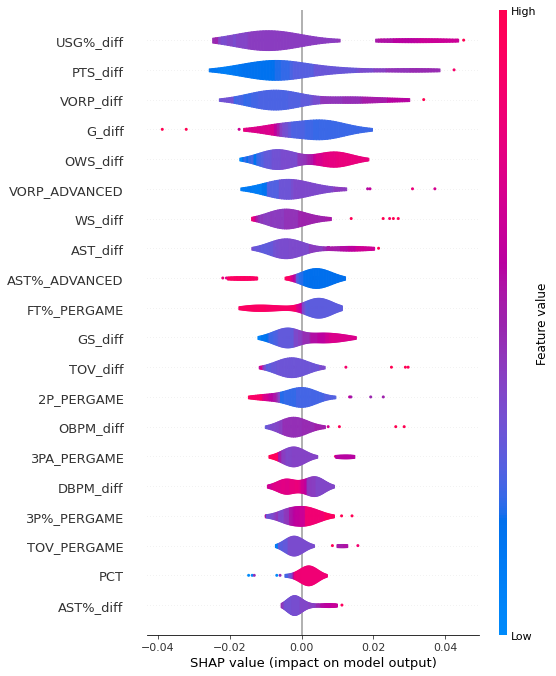

In [319]:
shap.summary_plot(shap_values, scaled_X_test_df,plot_type='violin') #X_test, plot_type='violin') # Top 20 variables

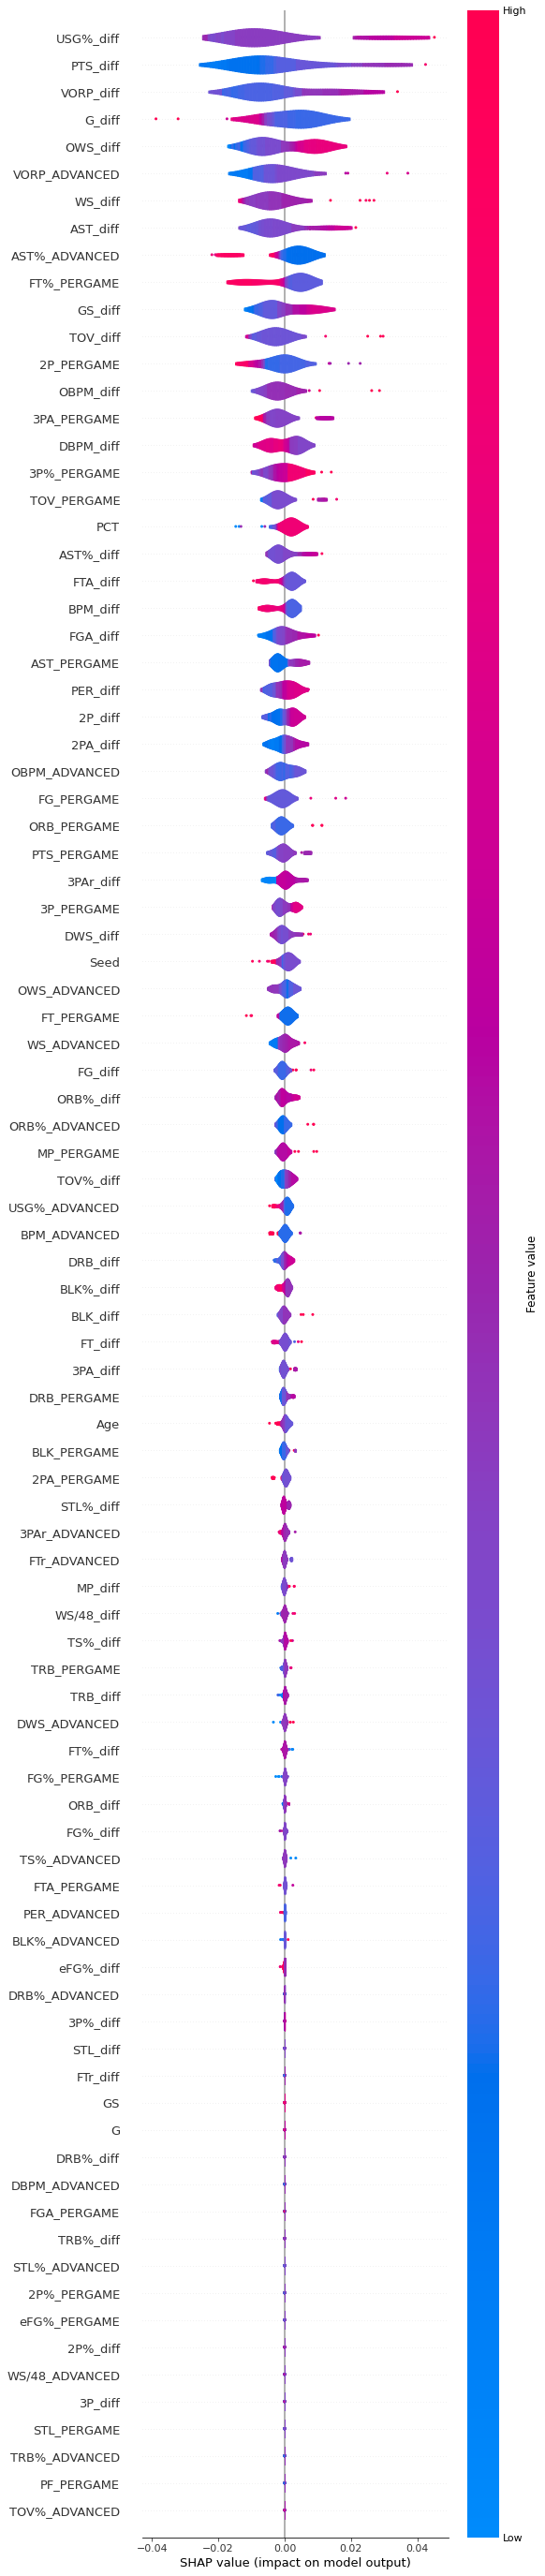

In [320]:
shap.summary_plot(shap_values, X_test, plot_type='violin', max_display=len(X_test.columns)) # All features